# Modeling relative strain prevalence

This notebook explores Pyro models for forecasting relative strain prevalance based on GISAID sequence data labeled with Pangolin lineage and kmer features.

In [1]:
import math
import pickle
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Trace_ELBO
from pyro.infer.autoguide import AutoDelta, AutoNormal, init_to_median
from pyro.optim import Adam, ClippedAdam
from pyrocov import pangolin

matplotlib.rcParams['figure.dpi'] = 200

## Loading data

We'll use all GISAID data. You'll need to request a feed from gisaid.org, download, then run
```sh
python preprocess_gisaid.py
python featurize_gisaid.py
```

In [2]:
with open("results/gisaid.columns.pkl", "rb") as f:
    columns = pickle.load(f)
print("Training on {} rows with columns:".format(len(columns["day"])))
print(", ".join(columns.keys()))

Training on 579250 rows with columns:
accession_id, collection_date, location, add_location, lineage, day


In [3]:
lineages = list(map(pangolin.compress, columns["lineage"]))
print(f"Top 12 of {len(set(lineages))} lineages")
print("-" * 30)
for lineage, count in Counter(lineages).most_common(12):
    print(f"{count: >10d} {lineage}")

Top 12 of 881 lineages
------------------------------
     90459 B.1.1.7
     81788 B.1.177
     54639 B.1
     34030 B.1.2
     19886 B.1.1.29
     15224 B.1.160
     12226 D.2
      8606 B.1.177.21
      7809 C
      6610 B.1.1.284
      6234 B.1.258
      6146 B.1.221


In [4]:
locations = columns["location"]
print(f"Top 12 of {len(set(locations))} lineages")
print("-" * 30)
for location, count in Counter(locations).most_common(12):
    print(f"{count: >10d} {location}")

Top 12 of 6225 lineages
------------------------------
    195058 Europe / United Kingdom / England
     26825 Europe / United Kingdom / Wales
     18946 Europe / Denmark / Hovedstaden
     16293 Europe / United Kingdom / Scotland
     15728 Asia / Japan
     13556 Oceania / Australia / Victoria
     12406 North America / USA / Texas / Houston
      7405 Europe / Denmark / Syddanmark
      7008 Europe / Denmark / Midtjylland
      6362 North America / USA / Michigan
      6089 Europe / Denmark / Sjaelland
      6040 North America / USA / Utah


In [5]:
kmer_features = torch.load("results/gisaid.kmer_features.pt")
print(kmer_features.keys())

dict_keys(['args', 'pangolin_mapping', 'lineages', 'features'])


In [6]:
print(kmer_features["features"].shape)

torch.Size([371, 32])


## Aggregating regions and lineages

We'll aggregate rare lineages into their parents, and aggregate locations by either US state, UK regions, or other country.

In [7]:
features = kmer_features["features"]
mapping = kmer_features["pangolin_mapping"]
lineages = list(map(pangolin.compress, columns["lineage"]))
lineages = [mapping.get(x, x) for x in lineages]
lineage_id_inv = kmer_features["lineages"]
lineage_id = {k: i for i, k in enumerate(lineage_id_inv)}

In [8]:
sparse_data = Counter()
location_id = {}
for day, location, lineage in zip(columns["day"], columns["location"], lineages):
    parts = location.split("/")
    if len(parts) < 2:
        continue
    parts = [p.strip() for p in parts[:3]]
    if parts[1] not in ("USA", "United Kingdom"):
        parts = parts[:2]
    location = " / ".join(parts)
    x = location_id.setdefault(location, len(location_id))
    s = lineage_id[lineage]
    t = day // 7
    sparse_data[t, x, s] += 1
    
T = 1 + max(columns["day"]) // 7
P = len(location_id)
S = len(lineage_id)
dense_data = torch.zeros(T, P, S)
for (t, p, s), n in sparse_data.items():
    dense_data[t, p, s] = n
print(dense_data.shape)

torch.Size([64, 227, 371])


## Constructing a Pyro model

Our first model is a logistic growth model with a Dirichlet-multinomial likelihood (the multivariate generalization of negative binomial likelihood). This ignores any spatial structure across regions.

In [9]:
def model(dense_data, features, feature_scale=1.0):
    assert dense_data.shape[-1] == features.shape[0]
    T, P, S = dense_data.shape
    S, F = features.shape
    time_plate = pyro.plate("time", T, dim=-2)
    place_plate = pyro.plate("place", P, dim=-1)
    time = torch.arange(float(T)) * 7 / 365.25  # in years
    time -= time.max()
    
    # Assume relative growth rate depends on kmer features but not time or place.
    log_rate_coef = pyro.sample(
        "log_rate_coef",
        dist.Laplace(0, feature_scale).expand([F]).to_event(1),
    )
    log_rate = pyro.deterministic("log_rate", log_rate_coef @ features.T)

    # Assume places differ only in their initial infection count.
    with place_plate:
        log_init = pyro.sample(
            "log_init",
            dist.Normal(0, 10).expand([S]).to_event(1),
        )

    # Finally observe overdispersed counts.
    concentration = pyro.sample("concentration", dist.LogNormal(2, 4))
    base_rate = (log_init + log_rate * time[:, None, None]).softmax(dim=-1)
    with time_plate, place_plate:
        pyro.sample(
            "obs",
            dist.DirichletMultinomial(
                total_count=dense_data.sum(-1).max(),
                concentration=concentration * base_rate,
                is_sparse=True,  # uses a faster algorithm
            ),
            obs=dense_data,
        )

## Fitting the model

We'll use simple MAP estimation via Pyro's SVI and an `AutoDelta` guide. I'm defining a custom initialization function to initialize forecasts to uniformly even rather than random.

In [10]:
def init_loc_fn(site):
    if site["name"] in ("log_init", "log_rate_coef"):
        return torch.zeros(site["fn"].shape())
    return init_to_median(site)

Traning guide with 84250 parameters:
step    0 loss = 13.4	conc. = 1.08
step   20 loss = 11.8	conc. = 2.78
step   40 loss = 11.1	conc. = 5.31
step   60 loss = 10.8	conc. = 7.14
step   80 loss = 10.6	conc. = 8.76
step  100 loss = 10.5	conc. = 10.9
step  120 loss = 10.5	conc. = 13.1
step  140 loss = 10.5	conc. = 14.8
step  160 loss = 10.4	conc. = 15.6
step  180 loss = 10.4	conc. = 16
step  200 loss = 10.4	conc. = 16.3
step  220 loss = 10.4	conc. = 16.4
step  240 loss = 10.4	conc. = 16.6
step  260 loss = 10.4	conc. = 16.7
step  280 loss = 10.4	conc. = 16.8
step  300 loss = 10.4	conc. = 16.8
CPU times: user 1min 7s, sys: 5.62 s, total: 1min 12s
Wall time: 34.2 s


Text(0, 0.5, 'loss')

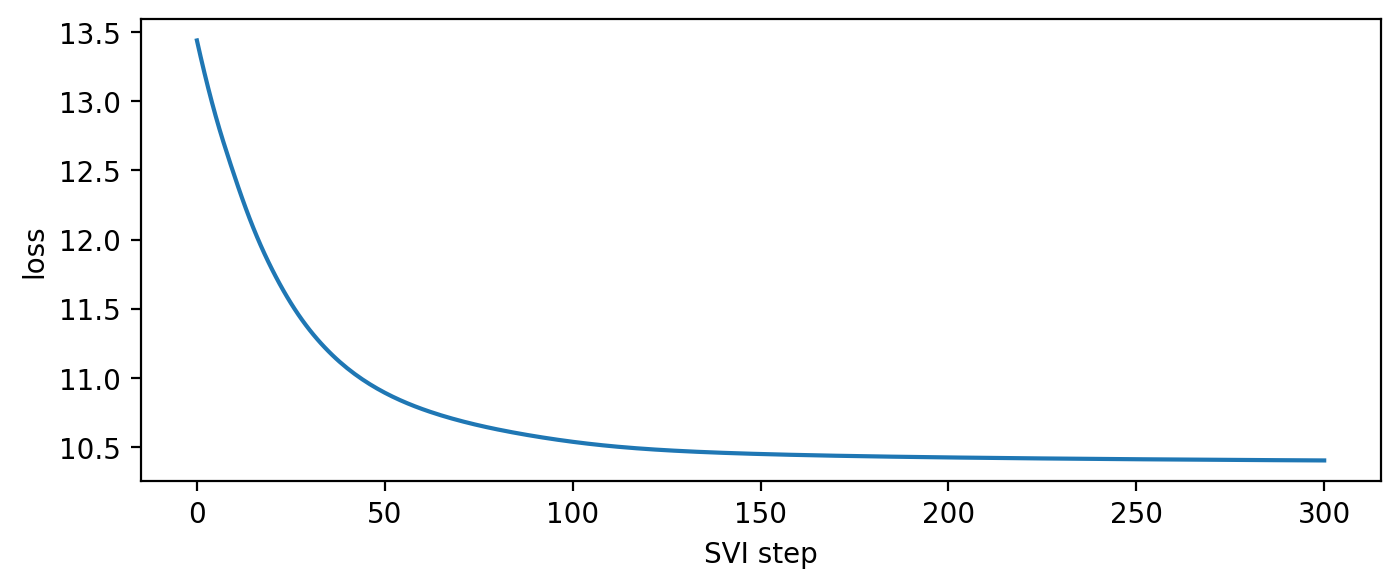

In [11]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(20210223)

num_steps = 301
guide = AutoDelta(model, init_loc_fn=init_loc_fn)
guide(dense_data, features)  # Initializes guide so we can count parameters.
print("Traning guide with {} parameters:".format(sum(p.numel() for p in guide.parameters())))
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, Trace_ELBO())
losses = []
num_obs = dense_data.count_nonzero()
for step in range(num_steps):
    loss = svi.step(dense_data, features) / num_obs
    assert not math.isnan(loss)
    losses.append(loss)
    if step % 20 == 0:
        median = guide.median()
        concentration = median["concentration"].item()
        print(f"step {step: >4d} loss = {loss:0.3g}\t"
              f"conc. = {concentration:0.3g}")
        
plt.figure(figsize=(8, 3))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("loss");

After fitting, we can extract a point estimate via the `guide.median()` method, which returns a dict.

In [12]:
with torch.no_grad():
    median = {k: v.detach() for k, v in guide.median().items()}
median["log_rate"] = median["log_rate_coef"] @ features.T
print(", ".join(median.keys()))

log_rate_coef, log_init, concentration, log_rate


## Interpreting results

Since we're fitting relative growth rate and prevalence, we can characterize all lineages by these quantities. Note the relative transmissibility looks suspciously diverse, suggesting we should probably add process noise to our model.

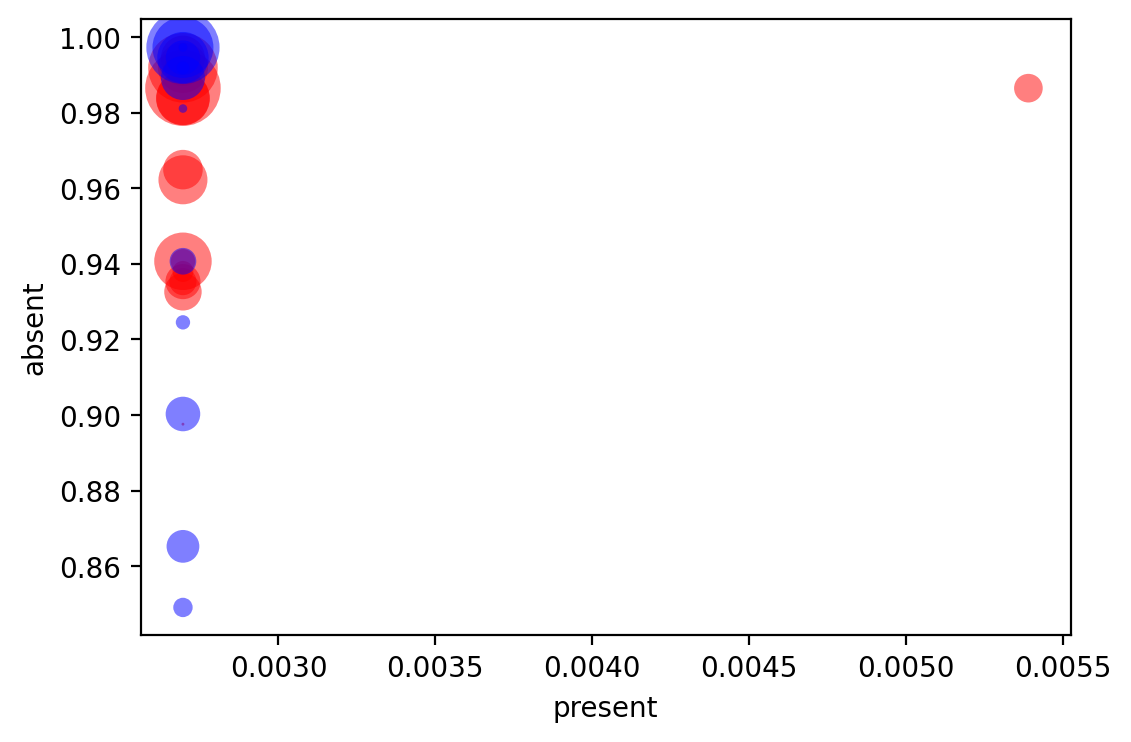

In [13]:
x = features.clamp(min=0).mean(0)
y = features.neg().clamp(min=0).mean(0)
coef = median["log_rate_coef"] * 100
pos = coef.clamp(min=0)
neg = coef.neg().clamp(min=0)
plt.figure(figsize=(6, 4))
plt.scatter(x, y, pos, color="red", alpha=0.5, lw=0)
plt.scatter(x, y, neg, color="blue", alpha=0.5, lw=0)
plt.xlabel("present")
plt.ylabel("absent");

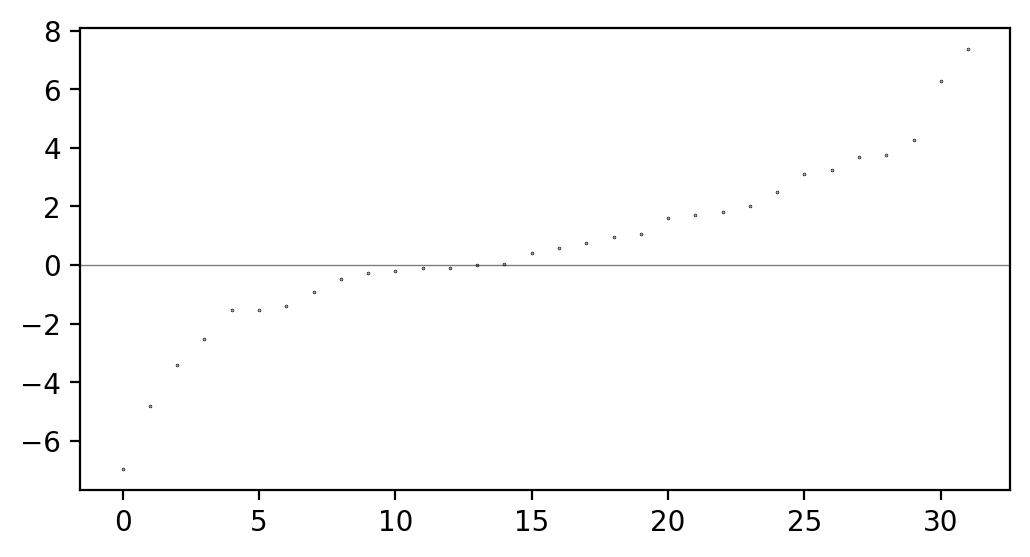

In [14]:
x = median["log_rate_coef"].sort(0).values
plt.figure(figsize=(6, 3))
plt.plot(x, 'k.', lw=0, markersize=0.5)
plt.axhline(0, color='black', lw=0.5, alpha=0.5);

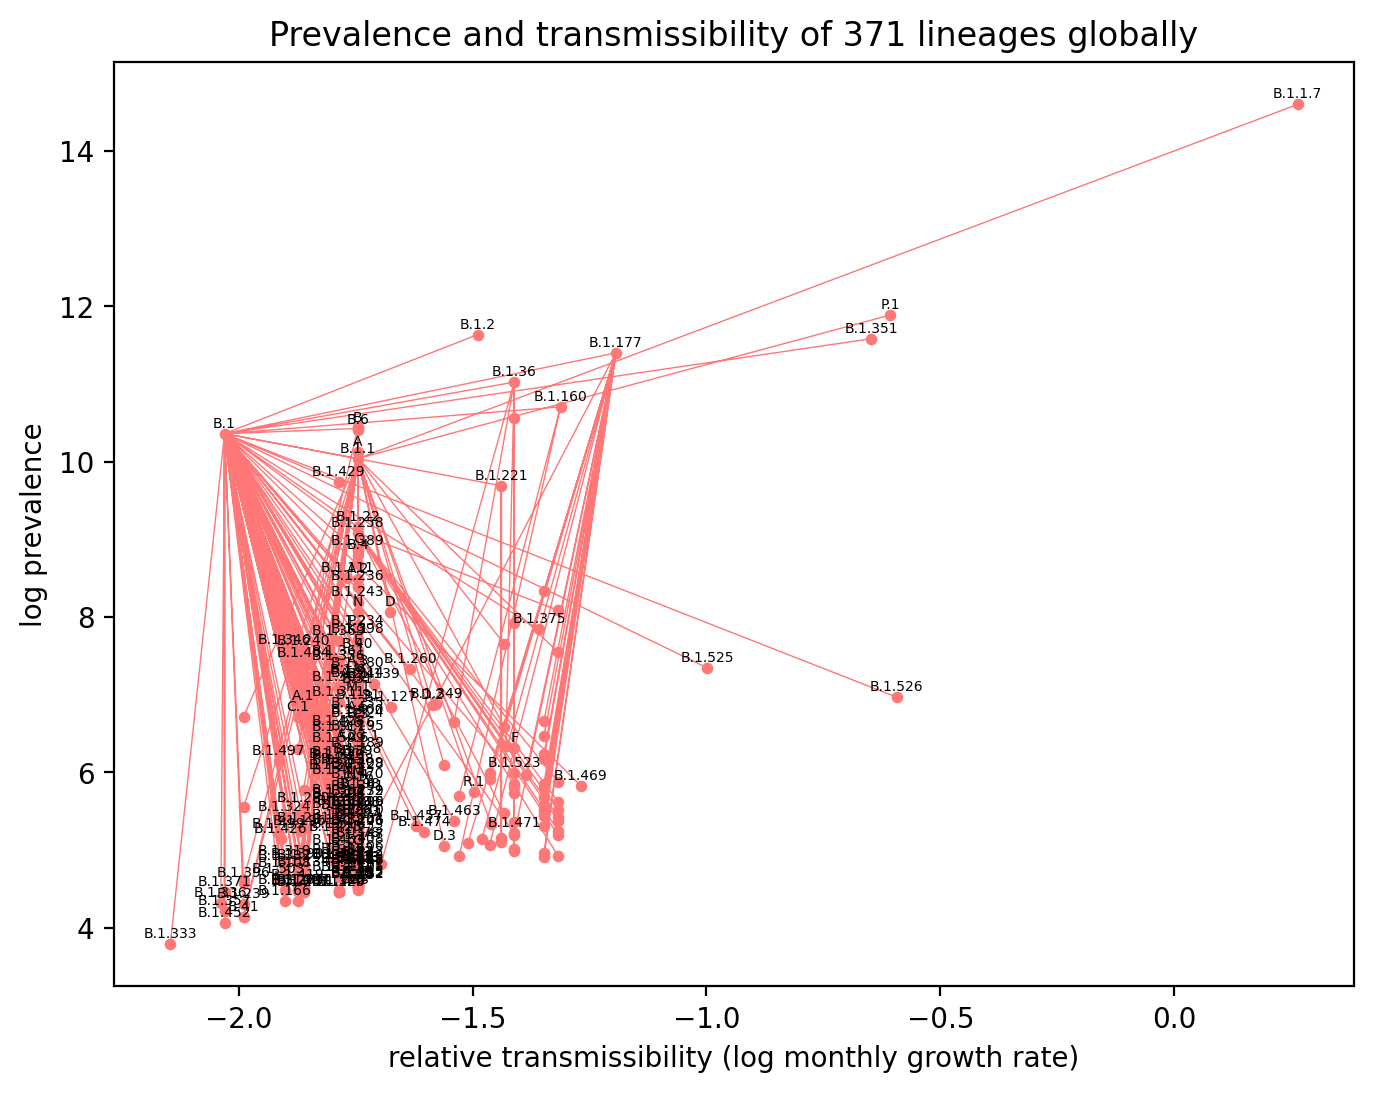

In [15]:
edges = pangolin.find_edges(list(lineage_id))
edges = torch.tensor([[lineage_id[u], lineage_id[v]] for u, v in edges], dtype=torch.long)

def plot_prevalence(place_query="", max_len=999):
    ids = [i for name, i in location_id.items() if place_query in name]
    local_lineages = dense_data.sum(0)[ids].sum(0).nonzero(as_tuple=True)[0]
    assert ids, "no locations matching " + place_query
    log_rate = median["log_rate"] / 12
    log_init = median["log_init"][ids].logsumexp(0)
    plt.figure(figsize=(8, 6))
    plt.scatter(log_rate[local_lineages], log_init[local_lineages], s=10, color="#ff7777")
    X, Y = [], []
    for u, v in edges.tolist():
        if u in local_lineages and v in local_lineages:
            X.extend([log_rate[u], log_rate[v], None])
            Y.extend([log_init[u], log_init[v], None])
    plt.plot(X, Y, color="#ff7777", lw=0.5)
    for name, i in lineage_id.items():
        if i in local_lineages and len(name) <= max_len:
            plt.text(log_rate[i], log_init[i] + 0.08, name,
                     fontsize=5, horizontalalignment="center")
    plt.ylabel("log prevalence")
    plt.xlabel("relative transmissibility (log monthly growth rate)")
    plt.title(f"Prevalence and transmissibility of {len(local_lineages)} lineages"
              + (" in " + place_query if place_query else " globally"));
    
plot_prevalence(max_len=7)

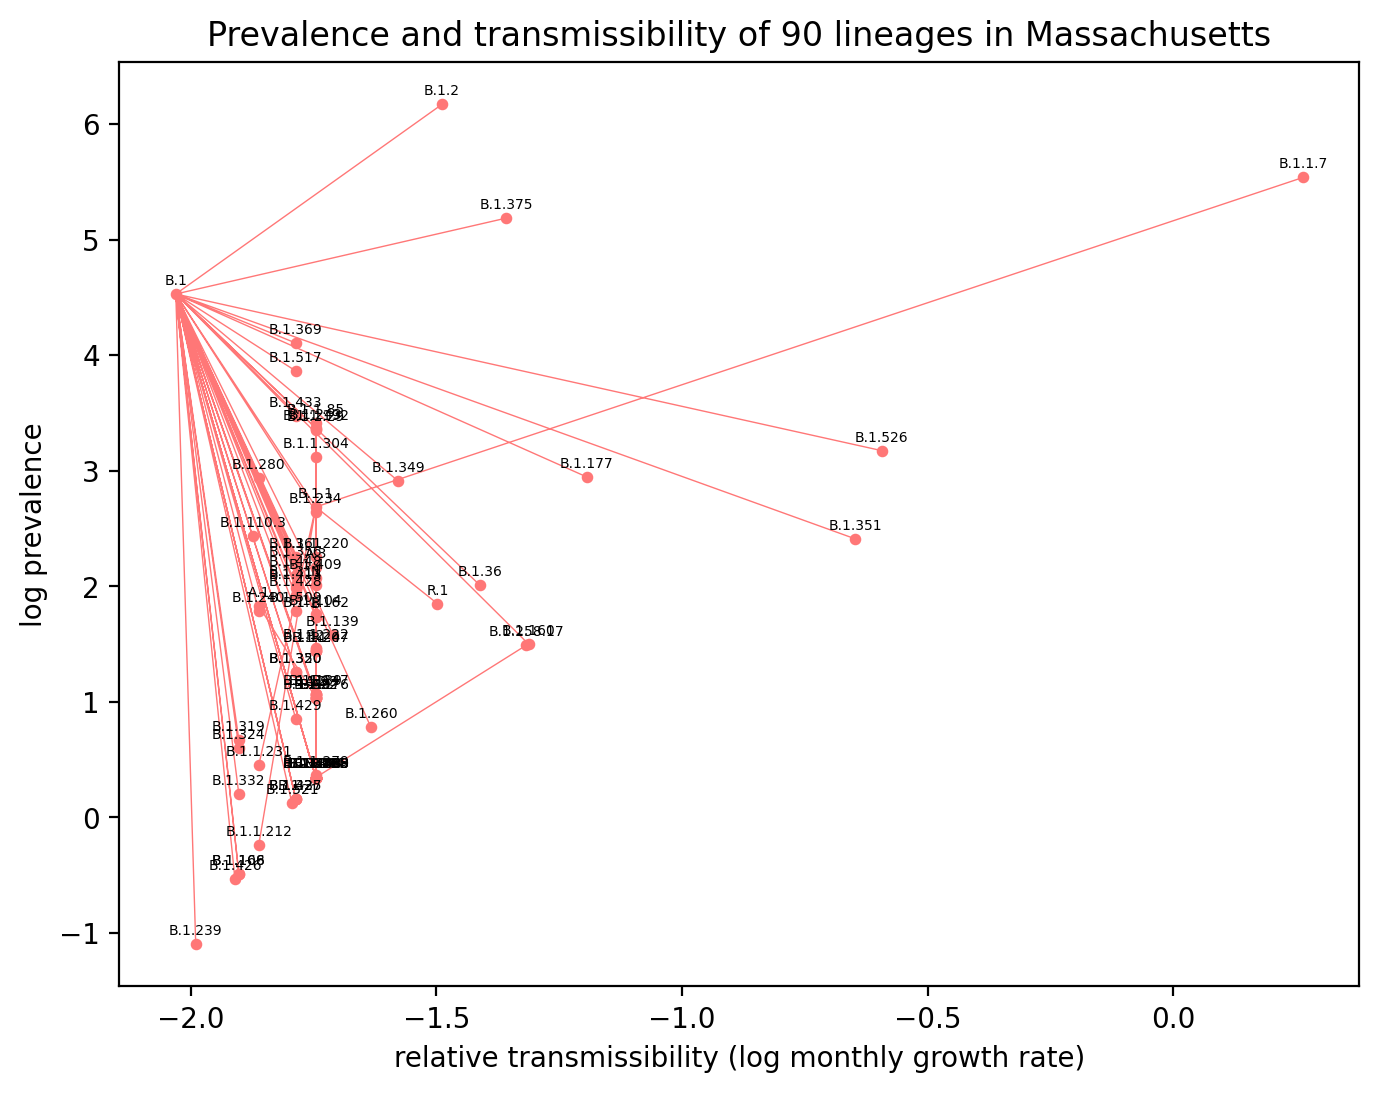

In [16]:
plot_prevalence("Massachusetts")

Finally we can use our logistic curves to forecast lineage prevalence in each region:

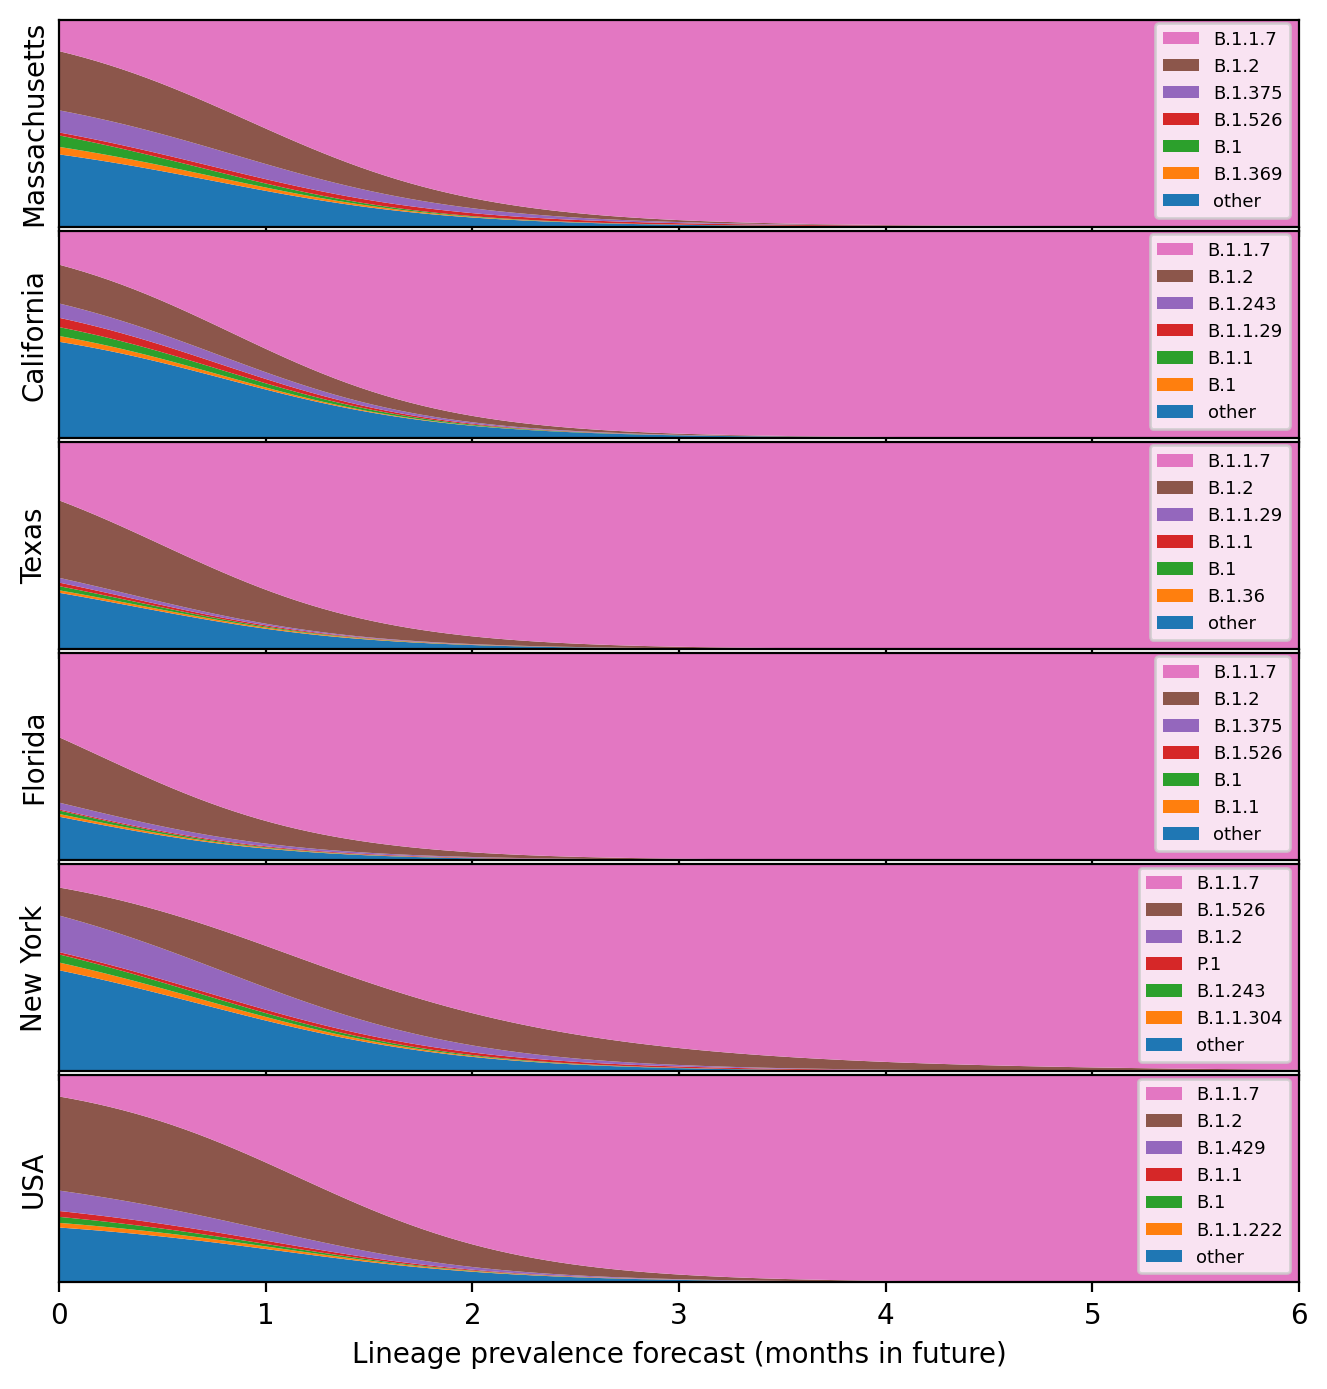

In [17]:
def plot_decomposition(queries, num_parts=7):
    if isinstance(queries, str):
        queries = [queries]
    fig, axes = plt.subplots(len(queries), figsize=(8, 1 + 1.2 * len(queries)), sharex=True)
    for row, (place_query, ax) in enumerate(zip(queries, axes)):
        names = [name for name, i in location_id.items() if place_query in name]
        ids = [location_id[name] for name in names]
        assert ids, "no locations matching " + place_query
        log_rate = median["log_rate"]
        # FIXME this ignores region population when aggregating:
        log_init = median["log_init"][ids].logsumexp(0)
        assert log_init.shape == log_rate.shape
        time = torch.linspace(0, 0.5, 100)
        portion = (log_init + log_rate * time[:, None]).softmax(-1)

        # Aggregate into top + others.
        best = portion.sum(0).sort(0, descending=True).indices
        parts = {"other": None}
        for i in range(num_parts - 1):
            i = best[num_parts - i - 2].item()
            parts[lineage_id_inv[i]] = portion[:, i].clone()
            portion[:, i] = 0
        parts["other"] = portion.sum(-1)
        months = time * 12

        ax.stackplot(months, *parts.values(), labels=tuple(parts))
        ax.set_xlim(months.min(), months.max())
        ax.set_ylim(0, 1)
        ax.set_yticks(())
        ax.set_ylabel(names[0].split("/")[-1].strip() if len(names) == 1 else place_query)
        if row == len(axes) - 1:
            ax.set_xlabel("Lineage prevalence forecast (months in future)")
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], loc="lower right", prop={"size": 6.5})
    plt.subplots_adjust(hspace=0.02);

plot_decomposition(["Mass", "Calif", "Texas", "Florida", "New York", "USA"])